U-net
======

https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

In [1]:
# install pytorch (http://pytorch.org/) if run from Google Colaboratory
import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip3 install https://download.pytorch.org/whl/{accelerator}/torch-1.1.0-{platform}-linux_x86_64.whl
    !pip3 install https://download.pytorch.org/whl/{accelerator}/torchvision-0.3.0-{platform}-linux_x86_64.whl

%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
from matplotlib import pyplot as plt

Parameter Settings
-------------------


In [2]:
# 2-d latent space, parameter count in same order of magnitude
# as in the original VAE paper (VAE paper has about 3x as many)
num_epochs = 100
batch_size = 128
learning_rate = 1e-3
use_gpu = True
image_size = 256


Data Loading
-------------------

We do not center images at 0, because we will be using a binary cross-entropy loss that treats pixel values as probabilities in [0,1]. We create both a training set and a test set.

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image, ImageOps

#from torchvision.datasets import FashionMNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

class CustomDataSet(Dataset):
    def __init__(self, input_dir=f'./five_cropped_input{image_size}',
                       output_dir=f'./five_cropped_output{image_size}', black_and_white=False, transform=None):
        self.input_dir = input_dir
        self.output_dir = output_dir
        if black_and_white:
            self.input_dir += '(bw)'
            self.output_dir += '(bw)'
        self.transform = transform
        self.total_imgs = os.listdir(self.input_dir)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc_in = os.path.join(self.input_dir, self.total_imgs[idx])
        img_loc_out = os.path.join(self.output_dir, self.total_imgs[idx])
        fig_in = ImageOps.invert(Image.open(img_loc_in))
        fig_out = ImageOps.invert(Image.open(img_loc_out))
        tensor_image_in = self.transform(fig_in)
        tensor_image_out = self.transform(fig_out)
        return tensor_image_in, tensor_image_out

full_dataset = CustomDataSet(input_dir=f'./five_cropped_input{image_size}',
                             output_dir=f'./five_cropped_output{image_size}', black_and_white=False, transform=img_transform)

train_size = 15000
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

#train_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#test_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [4]:
len(train_dataset), len(test_dataset), len(train_dataloader), len(test_dataloader)

(15000, 7030, 118, 55)

In [5]:
train_dataset[0][0].shape

torch.Size([1, 256, 256])

In [6]:
for batch, _ in train_dataloader:
    print(batch.shape)
    break

torch.Size([128, 1, 256, 256])


U-net
-----------------------
We use a convolutional encoder and decoder, which generally gives better performance than fully connected versions that have the same number of parameters.

In convolution layers, we increase the channels as we approach the bottleneck, but note that the total number of features still decreases, since the channels increase by a factor of 2 in each convolution, but the spatial size decreases by a factor of 4.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

In [7]:
import functools

class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.
        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Sigmoid()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)
    
class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)

unet = UnetGenerator(input_nc=1, output_nc=1, num_downs=5, ngf=16)

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
unet = unet.to(device)

num_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params, ', device: ', device)

Number of parameters: 1042081 , device:  cuda:0


Train U-net
--------

Training ...
Epoch [1 / 100] time: 73.04 (sec) average reconstruction error: 1305939.418763
Validation error: 526379.048864


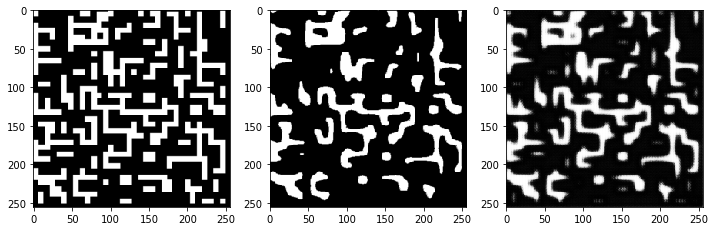

Epoch [2 / 100] time: 54.08 (sec) average reconstruction error: 425249.608647
Epoch [3 / 100] time: 54.04 (sec) average reconstruction error: 340110.717757
Epoch [4 / 100] time: 53.73 (sec) average reconstruction error: 316617.471928
Epoch [5 / 100] time: 52.94 (sec) average reconstruction error: 302930.997617
Epoch [6 / 100] time: 54.08 (sec) average reconstruction error: 296994.741128
Validation error: 287234.502273


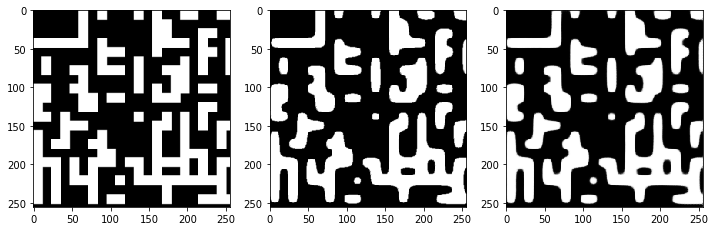

Epoch [7 / 100] time: 53.48 (sec) average reconstruction error: 288787.549424
Epoch [8 / 100] time: 53.77 (sec) average reconstruction error: 287058.271385
Epoch [9 / 100] time: 54.59 (sec) average reconstruction error: 287889.864936
Epoch [10 / 100] time: 53.37 (sec) average reconstruction error: 280406.856859
Epoch [11 / 100] time: 52.72 (sec) average reconstruction error: 278211.899563
Validation error: 279425.249716


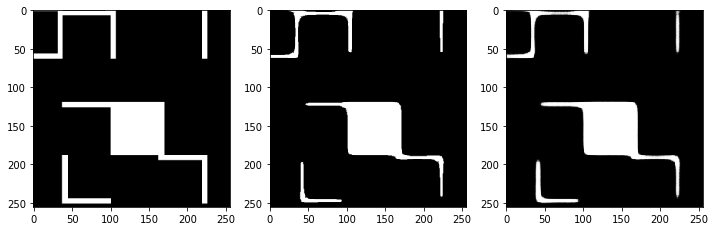

Epoch [12 / 100] time: 52.91 (sec) average reconstruction error: 278489.087262
Epoch [13 / 100] time: 53.19 (sec) average reconstruction error: 273180.193790
Epoch [14 / 100] time: 53.07 (sec) average reconstruction error: 275106.209613
Epoch [15 / 100] time: 53.79 (sec) average reconstruction error: 273994.619372
Epoch [16 / 100] time: 54.32 (sec) average reconstruction error: 273057.448689
Validation error: 277906.103125


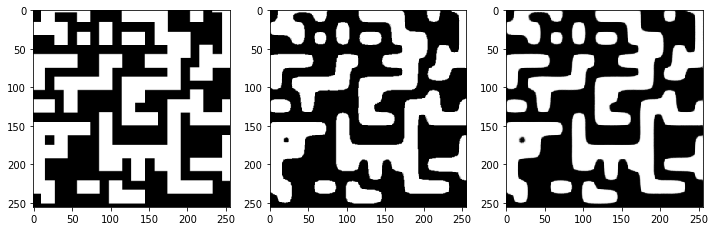

Epoch [17 / 100] time: 56.17 (sec) average reconstruction error: 270254.146253
Epoch [18 / 100] time: 53.67 (sec) average reconstruction error: 266838.782442
Epoch [19 / 100] time: 53.85 (sec) average reconstruction error: 266131.658865
Epoch [20 / 100] time: 55.05 (sec) average reconstruction error: 265633.135825
Epoch [21 / 100] time: 55.94 (sec) average reconstruction error: 266330.788798
Validation error: 271900.328977


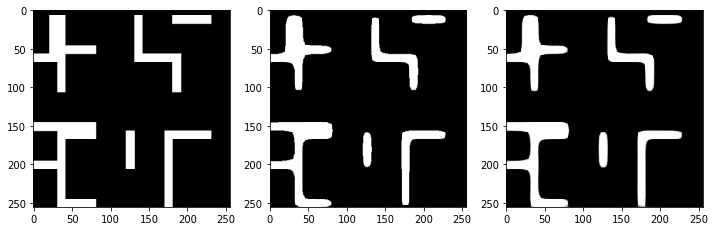

Epoch [22 / 100] time: 54.78 (sec) average reconstruction error: 264158.858349
Epoch [23 / 100] time: 55.96 (sec) average reconstruction error: 266978.544955
Epoch [24 / 100] time: 57.19 (sec) average reconstruction error: 261325.218055
Epoch [25 / 100] time: 55.34 (sec) average reconstruction error: 260575.037672
Epoch [26 / 100] time: 55.29 (sec) average reconstruction error: 262051.123146
Validation error: 277195.223580


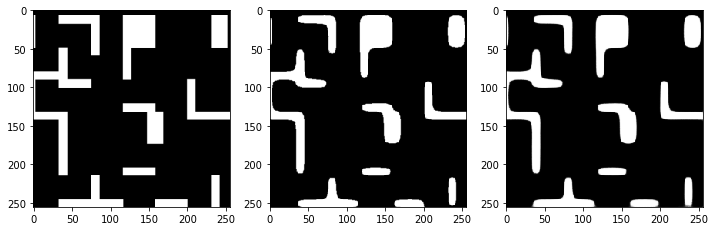

Epoch [27 / 100] time: 54.46 (sec) average reconstruction error: 259393.531283
Epoch [28 / 100] time: 53.37 (sec) average reconstruction error: 261052.204979
Epoch [29 / 100] time: 53.90 (sec) average reconstruction error: 259654.978350
Epoch [30 / 100] time: 55.21 (sec) average reconstruction error: 260616.928099
Epoch [31 / 100] time: 54.45 (sec) average reconstruction error: 255763.375761
Validation error: 270925.857670


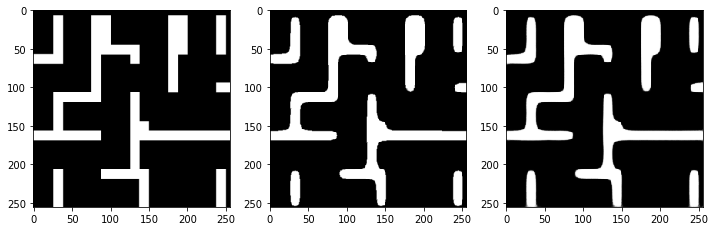

Epoch [32 / 100] time: 54.17 (sec) average reconstruction error: 256093.422074
Epoch [33 / 100] time: 54.95 (sec) average reconstruction error: 255509.908435
Epoch [34 / 100] time: 53.88 (sec) average reconstruction error: 258497.423994
Epoch [35 / 100] time: 54.09 (sec) average reconstruction error: 254763.634534
Epoch [36 / 100] time: 53.17 (sec) average reconstruction error: 254977.965837
Validation error: 288343.328977


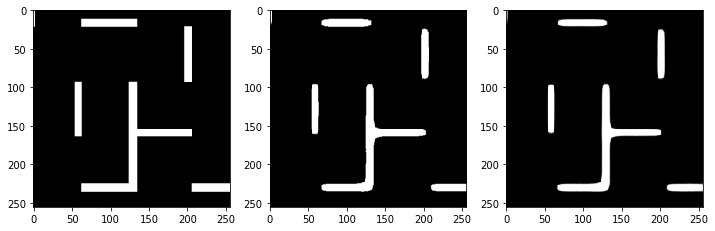

Epoch [37 / 100] time: 53.45 (sec) average reconstruction error: 253718.568392
Epoch [38 / 100] time: 54.36 (sec) average reconstruction error: 252997.438692
Epoch [39 / 100] time: 55.28 (sec) average reconstruction error: 252582.204648
Epoch [40 / 100] time: 55.31 (sec) average reconstruction error: 252077.329979
Epoch [41 / 100] time: 54.77 (sec) average reconstruction error: 252327.569187
Validation error: 273136.804261


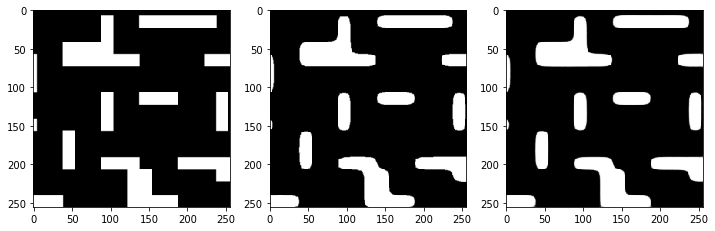

Epoch [42 / 100] time: 53.52 (sec) average reconstruction error: 252244.296014
Epoch [43 / 100] time: 53.36 (sec) average reconstruction error: 250316.346531
Epoch [44 / 100] time: 53.34 (sec) average reconstruction error: 250458.224642
Epoch [45 / 100] time: 53.37 (sec) average reconstruction error: 249580.271716
Epoch [46 / 100] time: 53.36 (sec) average reconstruction error: 250837.604078
Validation error: 272987.952557


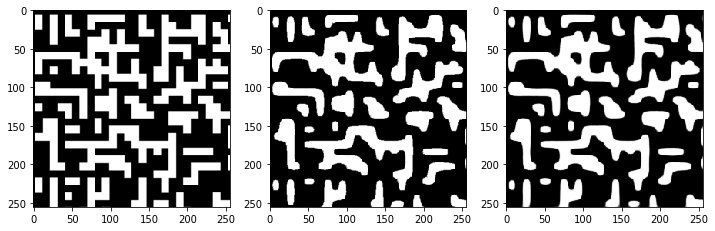

Epoch [47 / 100] time: 53.49 (sec) average reconstruction error: 248448.644531
Epoch [48 / 100] time: 53.48 (sec) average reconstruction error: 249993.038367
Epoch [49 / 100] time: 53.34 (sec) average reconstruction error: 248124.352489
Epoch [50 / 100] time: 53.44 (sec) average reconstruction error: 248518.842757
Epoch [51 / 100] time: 53.48 (sec) average reconstruction error: 248379.894862
Validation error: 271018.313068


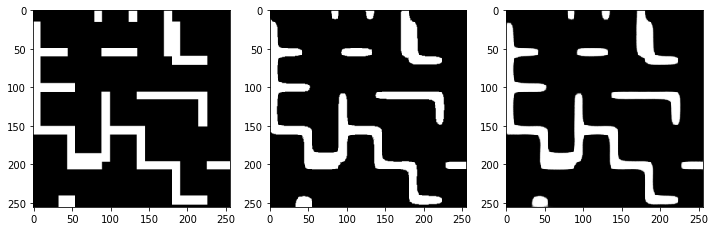

Epoch [52 / 100] time: 53.48 (sec) average reconstruction error: 247390.465870
Epoch [53 / 100] time: 53.47 (sec) average reconstruction error: 247233.596001
Epoch [54 / 100] time: 53.47 (sec) average reconstruction error: 246815.532773
Epoch [55 / 100] time: 53.65 (sec) average reconstruction error: 245625.171312
Epoch [56 / 100] time: 53.33 (sec) average reconstruction error: 246454.163136
Validation error: 271844.913636


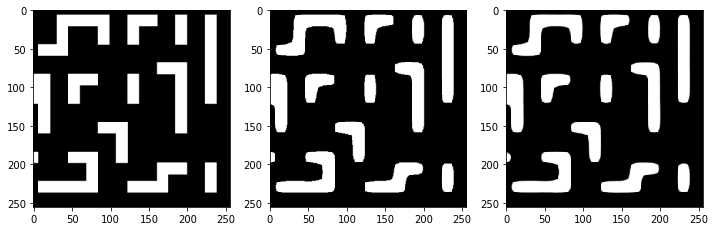

Epoch [57 / 100] time: 53.51 (sec) average reconstruction error: 245797.336202
Epoch [58 / 100] time: 53.37 (sec) average reconstruction error: 245793.706833
Epoch [59 / 100] time: 53.32 (sec) average reconstruction error: 245363.661679
Epoch [60 / 100] time: 53.24 (sec) average reconstruction error: 245411.302503
Epoch [61 / 100] time: 53.61 (sec) average reconstruction error: 244739.380561
Validation error: 272753.348011


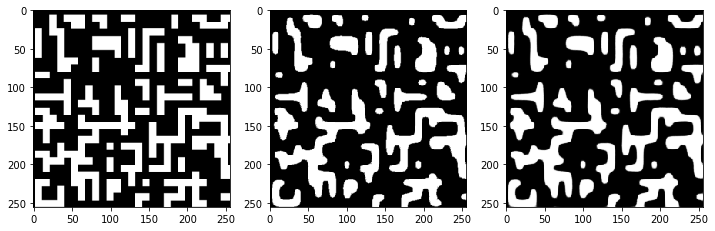

Epoch [62 / 100] time: 53.23 (sec) average reconstruction error: 244436.697564
Epoch [63 / 100] time: 53.73 (sec) average reconstruction error: 245267.312301
Epoch [64 / 100] time: 53.56 (sec) average reconstruction error: 244892.395127
Epoch [65 / 100] time: 53.41 (sec) average reconstruction error: 244116.948424
Epoch [66 / 100] time: 53.12 (sec) average reconstruction error: 245111.440347
Validation error: 274423.828409


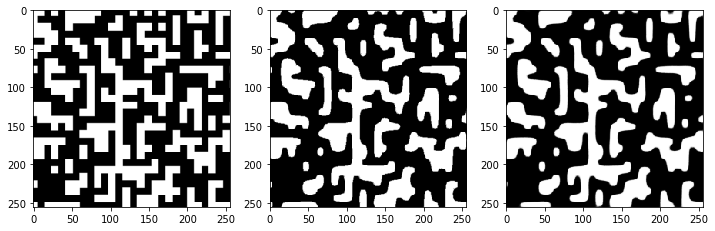

Epoch [67 / 100] time: 53.13 (sec) average reconstruction error: 244107.710573
Epoch [68 / 100] time: 53.11 (sec) average reconstruction error: 243832.327761
Epoch [69 / 100] time: 53.38 (sec) average reconstruction error: 243134.801476
Epoch [70 / 100] time: 53.45 (sec) average reconstruction error: 242676.441472
Epoch [71 / 100] time: 53.67 (sec) average reconstruction error: 243998.255661
Validation error: 279851.213636


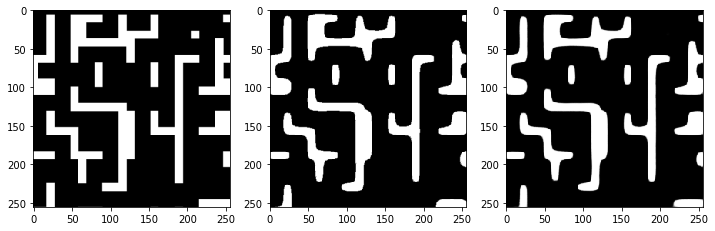

Epoch [72 / 100] time: 53.37 (sec) average reconstruction error: 242782.494902
Epoch [73 / 100] time: 53.37 (sec) average reconstruction error: 241798.552900
Epoch [74 / 100] time: 53.31 (sec) average reconstruction error: 242042.220339
Epoch [75 / 100] time: 53.33 (sec) average reconstruction error: 242675.874437
Epoch [76 / 100] time: 53.14 (sec) average reconstruction error: 242823.426708
Validation error: 274831.885227


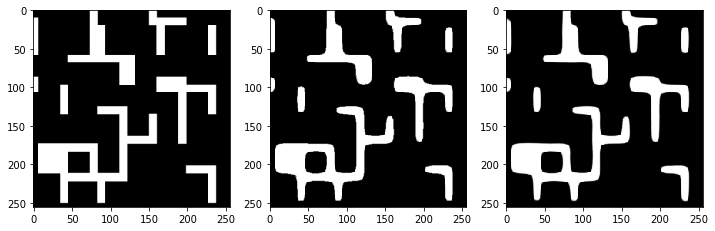

Epoch [77 / 100] time: 53.47 (sec) average reconstruction error: 242112.456899
Epoch [78 / 100] time: 53.19 (sec) average reconstruction error: 242514.796279
Epoch [79 / 100] time: 53.28 (sec) average reconstruction error: 242039.461335
Epoch [80 / 100] time: 53.65 (sec) average reconstruction error: 240949.268737
Epoch [81 / 100] time: 53.56 (sec) average reconstruction error: 240806.818061
Validation error: 274029.635227


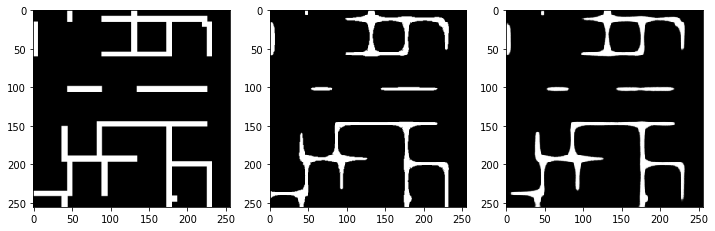

Epoch [82 / 100] time: 53.38 (sec) average reconstruction error: 241590.354145
Epoch [83 / 100] time: 53.28 (sec) average reconstruction error: 240274.271153
Epoch [84 / 100] time: 53.53 (sec) average reconstruction error: 241232.183594
Epoch [85 / 100] time: 53.56 (sec) average reconstruction error: 240315.837162
Epoch [86 / 100] time: 53.65 (sec) average reconstruction error: 239974.622021
Validation error: 281177.634943


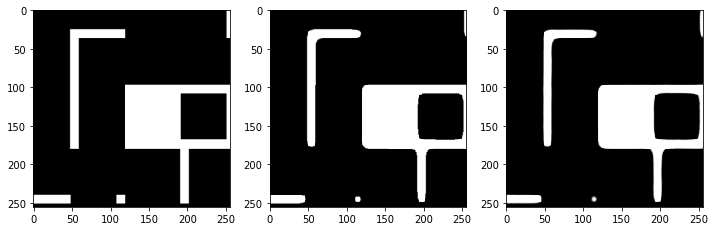

Epoch [87 / 100] time: 53.56 (sec) average reconstruction error: 241187.633706
Epoch [88 / 100] time: 53.67 (sec) average reconstruction error: 240457.492055
Epoch [89 / 100] time: 53.26 (sec) average reconstruction error: 240358.944816
Epoch [90 / 100] time: 53.41 (sec) average reconstruction error: 240144.193591
Epoch [91 / 100] time: 53.52 (sec) average reconstruction error: 239711.540850
Validation error: 280379.656250


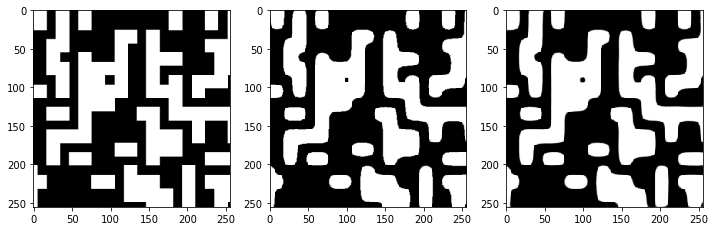

Epoch [92 / 100] time: 53.41 (sec) average reconstruction error: 238887.519862
Epoch [93 / 100] time: 53.33 (sec) average reconstruction error: 239020.373312
Epoch [94 / 100] time: 53.48 (sec) average reconstruction error: 238900.390493
Epoch [95 / 100] time: 53.55 (sec) average reconstruction error: 239131.864208
Epoch [96 / 100] time: 53.62 (sec) average reconstruction error: 239025.785256
Validation error: 279198.333807


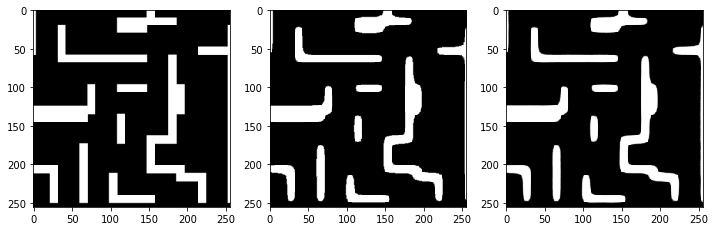

Epoch [97 / 100] time: 53.59 (sec) average reconstruction error: 239138.422769
Epoch [98 / 100] time: 54.51 (sec) average reconstruction error: 238459.454648
Epoch [99 / 100] time: 54.06 (sec) average reconstruction error: 238761.797868
Epoch [100 / 100] time: 54.05 (sec) average reconstruction error: 239494.849444


In [8]:
optimizer = torch.optim.Adam(params=unet.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
unet.train()

train_loss_avg = []
test_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    start_time = time.time()

    for image_batch, out_image_batch in train_dataloader:
        
        image_batch = image_batch.to(device)
        out_image_batch = out_image_batch.to(device)

        # unet reconstruction
        recon_image_batch = unet(image_batch)
        
        # reconstruction error
        loss = F.binary_cross_entropy(recon_image_batch.view(-1, image_size**2), 
                                        out_image_batch.view(-1, image_size**2), reduction='sum')

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
          
    train_loss_avg[-1] /= num_batches
    end_time = time.time()
    print('Epoch [%d / %d] time: %.2f (sec) average reconstruction error: %f' % (epoch+1, num_epochs, end_time-start_time, train_loss_avg[-1]))
      
    if epoch % 5 == 0:
        test_loss = []
        for image_batch, out_image_batch in test_dataloader:
            image_batch = image_batch.to(device)
            out_image_batch = out_image_batch.to(device)
            recon_image_batch = unet(image_batch)
            loss = F.binary_cross_entropy(recon_image_batch.view(-1, image_size**2), 
                                          out_image_batch.view(-1, image_size**2), reduction='sum')
            test_loss.append(loss.item())
        
        test_loss_avg.append(np.mean(test_loss))
        print('Validation error: %f' % (test_loss_avg[-1]))
        
        fig, ax = plt.subplots(1,3, figsize=(12,5))
        ax[0].imshow(image_batch[0].cpu().detach().squeeze(), cmap='gray')
        ax[1].imshow(out_image_batch[0].cpu().detach().squeeze(), cmap='gray')
        ax[2].imshow(recon_image_batch[0].cpu().detach().squeeze(), cmap='gray')
        plt.show()
        
        if not os.path.isdir('./Unet_checkpoints'):
            os.makedirs('./Unet_checkpoints')
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': unet.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_loss_avg,
                    'val_loss': test_loss_avg
                    }, './Unet_checkpoints/Unet_epoch_{}.pth'.format(epoch))

#         model = TheModelClass(*args, **kwargs)
#         optimizer = TheOptimizerClass(*args, **kwargs)

#         checkpoint = torch.load(PATH)
#         model.load_state_dict(checkpoint['model_state_dict'])
#         optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#         epoch = checkpoint['epoch']
#         loss = checkpoint['loss']

#         model.eval()
#         # - or -
#         model.train()

Plot Training Curve
--------------------

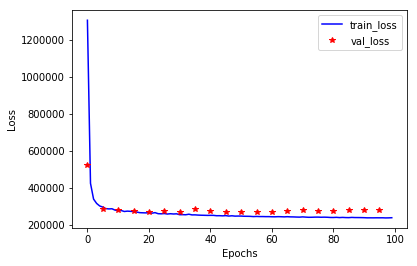

In [9]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg, 'b', label='train_loss')
plt.plot(range(0,100,5), test_loss_avg, 'r*', label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Alternatively: Load Pre-Trained VAE
-----------------------------

In [0]:
filename = 'vae_2d.pth'
# filename = 'vae_10d.pth'
import urllib
if not os.path.isdir('./pretrained'):
    os.makedirs('./pretrained')
print('downloading ...')
urllib.request.urlretrieve ("http://geometry.cs.ucl.ac.uk/creativeai/pretrained/"+filename, "./pretrained/"+filename)
vae.load_state_dict(torch.load('./pretrained/'+filename))
print('done')

# this is how the VAE parameters can be saved:
# torch.save(vae.state_dict(), './pretrained/my_vae.pth')

Evaluate on the Test Set
-------------------------

In [0]:
# set to evaluation mode
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
    
    with torch.no_grad():
    
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 19294.807126


Visualize Reconstructions
--------------------------

Original images


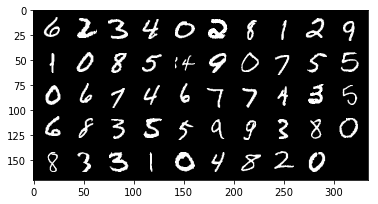

VAE reconstruction:


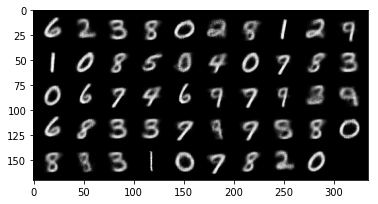

In [0]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

Interpolate in Latent Space
----------------------------

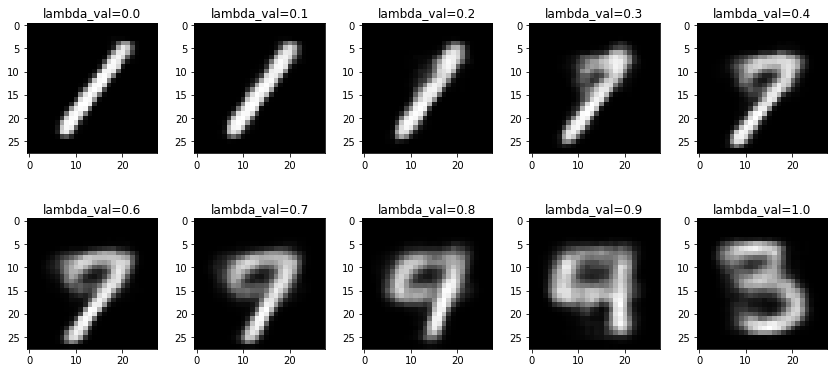

In [0]:
vae.eval()

def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
    
        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), vae, digits[7][0], digits[1][0])
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 

Sample Latent Vector from Prior (VAE as Generator)
-------------------------------------------------

A VAE can generate new digits by drawing latent vectors from the prior distribution. Although the generated digits are not perfect, they are usually better than for a non-variational Autoencoder (compare results for the 10d VAE to the results for the autoencoder).

Similar to autoencoders, the manifold of latent vectors that decode to valid digits is sparser in higher-dimensional latent spaces. Increasing the weight of the KL-divergence term in the loss (increasing `variational_beta`) makes the manifold less sparse at the cost of a lower-quality reconstruction. A pre-trained model with `variational_beta = 10` is available at `./pretrained/vae_10d_beta10.pth`.

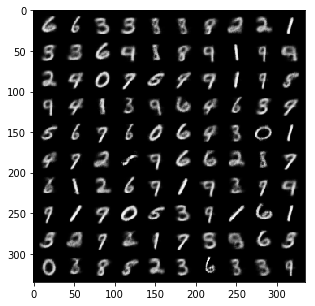

In [0]:
vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, latent_dims, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

Show 2D Latent Space
---------------------

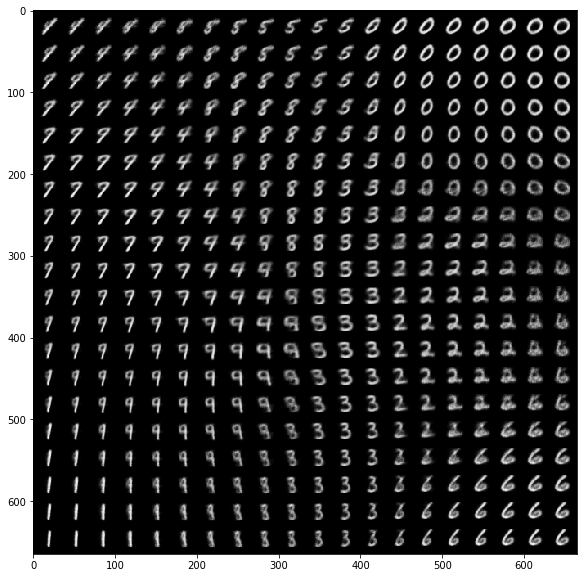

In [0]:
# load a network that was trained with a 2d latent space
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')
    
with torch.no_grad():
    
    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = vae.decoder(latents)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    plt.show()